### Importing the Required Libraries

This step prepares the dataset for machine learning by splitting it into features (X) and target variable (y). It then divides the data into training and testing sets to evaluate the model's performance, ensuring a robust assessment of its predictive capabilities.

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Load the cleaned dataset
data = pd.read_csv('Downloads/AirQualityUCI_Cleaned.csv')

# Split features and target variable
X = data.drop('C6H6(GT)', axis=1)
y = data['C6H6(GT)']

# Ensure the target variable is categorical
y = y.astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Q-learning for Feature Selection

This step uses Q-learning to identify the most important features for model training. The algorithm iteratively adjusts the feature set, training a temporary model to evaluate the impact of each feature removal on accuracy, and updates the Q-table to guide feature selection, ultimately selecting the best subset of features.

In [3]:
# Q-learning parameters
n_actions = X_train.shape[1]
n_states = 1  # This is a simplification; normally you'd have more complex states.
q_table = np.zeros((n_states, n_actions))
learning_rate = 0.1
discount_factor = 0.9
episodes = 1000
epsilon = 0.1  # Exploration factor

# Q-learning algorithm
for episode in range(episodes):
    state = 0  # Simplified state
    done = False
    while not done:
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.choice(range(n_actions))
        else:
            action = np.argmax(q_table[state])

        # Modify the feature set based on the action
        selected_features = X_train.columns.tolist()
        if action < len(selected_features):
            selected_features.remove(selected_features[action])

        # Train a temporary model to evaluate the action
        temp_model = DecisionTreeClassifier(random_state=42)
        temp_model.fit(X_train[selected_features], y_train)
        y_pred = temp_model.predict(X_train[selected_features])
        reward = accuracy_score(y_train, y_pred)

        # Update Q-value
        best_next_action = np.argmax(q_table[state])
        td_target = reward + discount_factor * q_table[state, best_next_action]
        td_error = td_target - q_table[state, action]
        q_table[state, action] += learning_rate * td_error

        done = True

# Select the best features based on Q-learning
best_action = np.argmax(q_table[0])
selected_features = X_train.columns.tolist()
if best_action < len(selected_features):
    selected_features.remove(selected_features[best_action])

### Hyperparameter Tuning and Model Evaluation for RandomForest after Q-Learning Feature Selection

This step fine-tunes the hyperparameters of a RandomForestClassifier using GridSearchCV, trains the best model on features selected by Q-learning, and evaluates its performance. It also visualizes feature importance, highlighting the contribution of each selected feature to the model's predictions.

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/anaconda3/envs/NLP/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Q-Learning Classifier Accuracy: 0.9961149961149961
Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00       286
           0       1.00      1.00      1.00      1889
           1       1.00      1.00      1.00       266
           2       0.97      1.00      0.98        96
           3       0.85      0.88      0.86        25
           4       0.71      0.56      0.63         9
           5       1.00      0.33      0.50         3

    accuracy                           1.00      2574
   macro avg       0.93      0.82      0.85      2574
weighted avg       1.00      1.00      1.00      2574



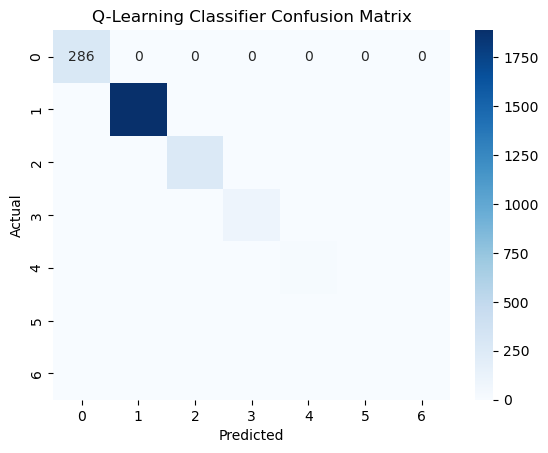

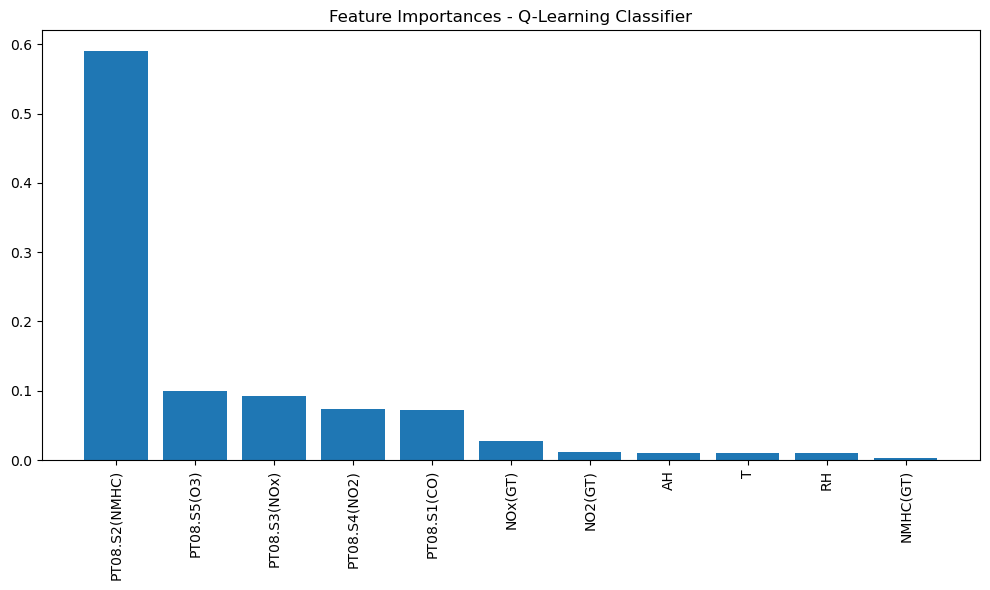

In [5]:
# Hyperparameter tuning for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train[selected_features], y_train)

# Best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train[selected_features], y_train)

# Predict and evaluate
y_pred_test = best_model.predict(X_test[selected_features])
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Q-Learning Classifier Accuracy: {accuracy_test}")
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Q-Learning Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - Q-Learning Classifier")
plt.bar(range(len(selected_features)), importances[indices], align='center')
plt.xticks(range(len(selected_features)), [selected_features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()